In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
from gridworld.environment import WindyGridworld

## Learning $\pi_b$ from $\mathcal{D} = \{s,a,s',r\}$

In [2]:
def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']

means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("dataset_large.npz") #We're using dataset_large and dataset_knn
print(trajectories.shape)
print(rewards.shape)
print(unique_concepts.shape)
print(concepts.shape)
print(actions.shape)
print(means.shape)
print(clusters.shape)


num_concepts = len(means)
env = WindyGridworld(num_concepts=num_concepts, method="simple", knn=None, means=means, policy_model=None)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(653,)
(653,)
(653,)
(653,)
(653,)
(5, 2)
(500, 2)


# Data pre-processing

In [3]:
A = env.A

def generate_default_dataset(window_size):
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    Y = actions_indexed.reshape(len(actions_indexed), 1)
    # Y = np.concatenate(actions)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, 4), to_categorical(y_test, 4)

def window_states(trajectories, W_s=30):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    windowed_trajectories = []
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')

def actions_to_action_indexes(actions):
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    indicies = [np.where(np.all((A == a), axis=1))[0][0] for a in actions]
    return np.array(indicies)

## Model

In [6]:
from models.policy import PolicyModel

X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5)
print(X_train.shape)
print(y_train.shape)
pi_b = PolicyModel(input_size=X_train[0].shape, num_actions=4).build()
history = pi_b.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

(322004, 2)
(322004, 4)
Epoch 1/10
8051/8051 [==============================] - 11s 1ms/step - loss: 1.3045 - categorical_accuracy: 0.3543 - val_loss: 1.3013 - val_categorical_accuracy: 0.3552
Epoch 2/10
8051/8051 [==============================] - 9s 1ms/step - loss: 1.3028 - categorical_accuracy: 0.3555 - val_loss: 1.3015 - val_categorical_accuracy: 0.3570
Epoch 3/10
8051/8051 [==============================] - 9s 1ms/step - loss: 1.3026 - categorical_accuracy: 0.3561 - val_loss: 1.3011 - val_categorical_accuracy: 0.3578
Epoch 4/10
8051/8051 [==============================] - 9s 1ms/step - loss: 1.3025 - categorical_accuracy: 0.3569 - val_loss: 1.3010 - val_categorical_accuracy: 0.3580
Epoch 5/10
8051/8051 [==============================] - 9s 1ms/step - loss: 1.3024 - categorical_accuracy: 0.3574 - val_loss: 1.3012 - val_categorical_accuracy: 0.3570
Epoch 6/10
8051/8051 [==============================] - 9s 1ms/step - loss: 1.3025 - categorical_accuracy: 0.3557 - val_loss: 1.3012 - 

In [7]:
p = np.array([1,-1])
p = p.reshape((1,2))
actions = pi_b.predict(X_test)
print(actions)
predicted_actions = np.argmax(actions, axis=1)
print(predicted_actions[0:200])

[[0.34836856 0.15308051 0.35067433 0.14787659]
 [0.3434281  0.15419361 0.3581245  0.14425382]
 [0.34114912 0.15498245 0.36019796 0.14367045]
 ...
 [0.35164317 0.15289234 0.34486452 0.1506    ]
 [0.34442005 0.15357569 0.35737503 0.14462923]
 [0.3478173  0.1523053  0.35437784 0.14549956]]
[2 2 2 0 2 2 2 2 0 2 2 0 2 2 0 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2
 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 0 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2
 2 2 2 2 2 2 2 0 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 0 2 0 2 2 2 0 2 2 2 2 2
 0 0 0 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 0 0 0 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 2 0 0 0 2 2 0 0 0 0 2 2 0 2 2 0 2 0 0 2 2 2 2 0 2 2 2
 2 2 2 2 2 2 2 0 0 2 2 0 2 2 2]


In [11]:
# up = [0, 1]
# down = [0, -1]
# right = [1, 0]
# left = [-1, 0]

# A = np.array([up, down, right, left])


# def policy(state):
#     indices = [0, 1, 2, 3]
#     # higher probability of moving up and right
#     return A[np.random.choice(indices, 1, p=[0.35, 0.15, 0.35, 0.15])[0]]


# def reached_goal(s):
#     if s.shape[0] == 1:
#         s = s[0]
#     return s[0] >= 3 and s[0] <= 4 and s[1] >= 3 and s[1] <= 4


# def wind_simple(s, means):
#     severities = [0.1, 0.3, 0.5, 0.7, 0.9]  # Wind severity per cluster
#     distances = []
#     for i in range(num_concepts):
#         distances.append(np.linalg.norm(s - means[i]))
#     assigned_cluster = np.argmin(distances)
#     return severities[assigned_cluster]*np.array([-1, -1]), assigned_cluster

# def wind_knn(s):
  
#     severities = [0.1, 0.3, 0.5, 0.7, 0.9]  # Wind severity per cluster
#     assigned_cluster = knn.predict(s.reshape(1,2))[0]
   
#     return severities[assigned_cluster]*np.array([-1, -1]), assigned_cluster


# def wind(s, means):
#     # Different clusters experience different levels of wind
#     # Calculate wind as weighted average of wind experienced by different clusters, weighted by distance to centroids
#     s = s[0]
#     severities = [0.1, 0.3, 0.5, 0.7, 0.9]  # Wind severity per cluster
#     assigned_cluster = 0 #c is function of s
#     distances = []

#     for i in range(num_concepts):
#         distances.append(np.linalg.norm(s - means[i]))

#     assigned_cluster = np.argmin(distances)
#     return severities[assigned_cluster]*np.array([-1, 0]), severities[assigned_cluster]


# def play(saveOnGoalReached=False, trajectories=[], rewards=[], unique_concepts=[], concepts=[], actions=[], s=np.array([-3, -2])):
#     T = 1000 #Maximum episode length
#     alpha = 0.08
#     beta = 0.01
#     history = []
#     concept_history = []
#     action_history = []
#     reward = 0
#     visited_concepts = []
#     for _ in range(1, T):
#         s_pred = s.reshape((1,2))
#         action_index = np.argmax(pi_b.predict(s_pred)) #predict actions using pi_b
#         action = A[action_index]
#         wind_value, concept = wind_simple(s, means)
#         s = s + alpha*action + beta*wind_value  # transition

#         history.append(s)
#         concept_history.append(concept)
#         action_history.append(action)
#         if concept not in visited_concepts:
#             visited_concepts.append(concept)
#         if reached_goal(s):
#             if saveOnGoalReached:
#                 trajectories.append(np.array(history))
#                 concepts.append(np.array(concept_history))
#                 actions.append(np.array(action_history))
#                 rewards.append(np.array(reward))
#                 visited_concepts.sort()
#                 unique_concepts.append(visited_concepts)
#             break
#         reward -= 1

#     history = np.array(history)
#     return history



-3.0
-2.3333333333333335
-1.6666666666666667
-1.0
-0.3333333333333335
0.33333333333333304
1.0
1.666666666666666
2.333333333333333
3.0


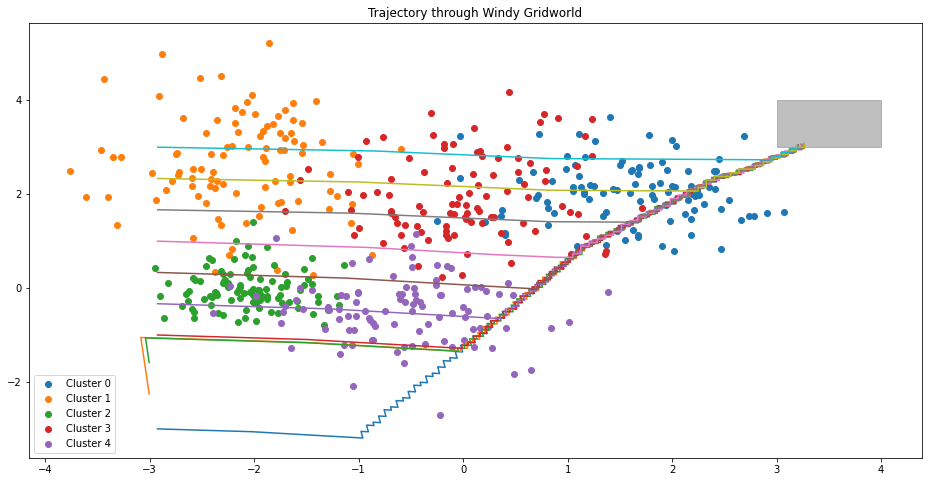

In [8]:
fig, ax2 = plt.subplots(figsize=(16,8))
predicted_actions = []

env.policy_model = pi_b #set policy of agent in the environment

for y in np.linspace(-3,3,10):
    print(y)
    history = env.play(True, [], [], [], [], predicted_actions, s = np.array([-3, y]))
    plt.plot(history[:, 0], history[:, 1])

rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*100
    end = (i+1)*100
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()

## Evaluation Policies $\pi_e(a|c=f(\cdot))$

These can be created in any way but should try achieve the same goal in the environment as the behavioural policy, and should be created with varying degrees of similarity to the behavioural policy.

### $\pi_e(a|c=f(s))$